<a href="https://colab.research.google.com/github/euan-nr/TTC-Incident-Reporting/blob/main/TTC_Delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [3]:
#Pull Delay Codes
codes_sub=gc.open_by_url("https://docs.google.com/spreadsheets/d/1h5eQZ2vosuBK7w4nUGVBtkdeU7jaPqtRyk6CbUp1oxs/edit#gid=1925460578").sheet1
values = codes_sub.get_all_values()
codes_sub = pd.DataFrame(values[1:],columns=values[0])
codes_srt=gc.open_by_url("https://docs.google.com/spreadsheets/d/12VERUjC0vH_IXXMjwPE5i3aPZjOXhONBvZtpvvRxXxU/edit#gid=2004182443").sheet1
values = codes_srt.get_all_values()
codes_srt = pd.DataFrame(values[1:],columns=values[0])

In [83]:
#Pull all TTC delay reports from 2018-22
ttc2018 = gc.open_by_url('https://docs.google.com/spreadsheets/d/10TuyNMtIPxV-f6ipie52ZSH_S0Q3u-vbZcowTvbjriw/edit#gid=608361424')
ttc2019 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1niNiXHoWzEnJQ6FMxWcqybMUy9SLwn5p9exX6XM3EbI/edit#gid=1588468639')
ttc2020 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1HU5Ydhddg9FbFIWOgd7rbd_ybWfE2mWjYF5H8NesVGM/edit#gid=709672757')
ttc2021 = gc.open_by_url('https://docs.google.com/spreadsheets/d/15VCs-DbYX5LRy3Pdq_XOZViqpHXFum5wwwNtOxPT05I/edit#gid=608057869')
ttc2022 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1cmAnAFmol51KvdVYvXWElBKGwpU8fUZtBIvTJxx5rmU/edit#gid=1839550723')
ttc2023 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1aa2Is_pqP6hcDYZUZPenhS8wSVV17RjAa6hzlALHbJ4/edit#gid=1800918964')
listChange = [ttc2018,ttc2019,ttc2020,ttc2021,ttc2022,ttc2023]

In [109]:
#Create combined DataFrame for all incidents 2018-2023
#Run to reload data and reset dataframe
listFrames=[]
for wb in listChange:
  for sheets in wb.worksheets():
    rows = sheets.get_all_values()
    df=pd.DataFrame.from_records(rows[1:],columns=rows[0])
    listFrames.append(df)
df=pd.concat(listFrames,ignore_index=True)

In [110]:
#Convert data to workable types
df['Datetime']=pd.to_datetime(df['Date']+' '+df['Time'])
cols = df.columns.tolist()  # Get the list of column names
cols = ['Datetime'] + cols[:-1]  # Move 'Datetime' to the first position
df = df[cols]  # Reorder the columns in the DataFrame
df['Day']=df['Day'].astype(str)
df['Station']=df['Station'].astype(str)
df['Code']=df['Code'].astype(str)
df['Min Delay']=df['Min Delay'].astype(int)
df['Min Gap']=df['Min Gap'].astype(int)
df['Bound']=df['Bound'].astype(str)
df['Line']=df['Line'].astype(str)
df['Vehicle']=df['Vehicle'].astype(str)

In [111]:
#Filter for all incidents which caused a delay
df=df.drop(['Date','Time'],axis=1)
df=df[df['Min Delay']>0]
df_test=df

In [ ]:
df.dtypes

In [ ]:
df_test

In [ ]:
#Check all years are recorded
year_list=df["Datetime"].dt.year.unique()
year_list

In [ ]:
#UNFILTERED STATIONS do not run
station_list2=df_test["Station"].unique().tolist()
station_counts2=df_test['Station'].value_counts().sort_index()
for station2, count2 in station_counts2.items():
    print(station2, count2)

In [112]:
#Cleaning Station Names
#Fix spelling errors in Station column
df['Station'] = df['Station'].str.replace(r'\s*STATION.*', ' STATION', regex=True) #Remove words after STATION
df['Station'] = df['Station'].str.replace("ST\.", "ST", regex=True) #Replace ST. with ST
df['Station'] = df['Station'].replace({
    'BATHUSRT STATION': 'BATHURST STATION',
    'BESSARIAN STATION': 'BESSARION STATION',
    'SATION': 'STATION',
    'BUID-UP':'BUILD-UP',
    'BUILD UP':'BUILD-UP',
    'BUILDD-UP':'BUILD-UP',
    'BUIDUP':'BUILD-UP',
    'DOWNVIEW PARK STATION':'DOWNSVIEW PARK STATION',
    'STAT' : 'STATION',
    'STATIO':'STATION',
    ' STATION' : 'STATION',
    'SHEPPARD YONGE STATION':'SHEPPARD-YONGE STATION',
    'SHEPPARD- YONGE STATION':'SHEPPARD-YONGE STATION',
    'YONGE SHEP STATION': 'SHEPPARD-YONGE STATION',
    'YONGE SHP STATION': 'SHEPPARD-YONGE STATION',
    'GLENCARIN STATION':'GLENCAIRN STATION',
    'VMC STATION' : 'VAUGHAN MC STATION',
    'FICNH STATION' : 'FINCH STATION',
    'LAWERENCE STATION':'LAWRENCE STATION',
    'MC COWAN STATION' : 'MCCOWAN STATION',
    'BLOOR STATION' : 'BLOOR-YONGE STATION',
    'YONGE STATION' : 'BLOOR-YONGE STATION',
    'SHEPHARD WEST STATION' : 'SHEPPARD WEST STATION',
    'SHEPPHARD WEST STATION' : 'SHEPPARD WEST STATION',
    'BAY LOWER STATION':'BAY STATION',
    'EGLINTON PSUDO STATION':'EGLINTON STATION',
    'KENNEDY SRT STATION':'KENNEDY STATION',
    'PIONEER VILLAGE STATIO': 'PIONEER VILLAGE STATION',
    'EGLINGTON STATION':'EGLINTON STATION',
    'YORK UNIVERSITY STATIO':'YORK UNIVERSITY STATION',
    'SCARBOROUGH CTR STATIO':'SCARBOROUGH CENTRAL STATION',
    'SCARB CTR STATION':'SCARBOROUGH CENTRAL STATION',
    'SCARBOROUGH CENTRE STA':'SCARBOROUGH CENTRAL STATION',
})
df['Station'] = df['Station'].str.replace("QUEENS", "QUEEN'S", regex=False) #Correct naming of Queen's Park
df['Station'] = df['Station'].str.replace(r"\b\w+\sTO\s(.+?\s)?STATION\b", "STATION", regex=True) #Removing "TO X" before station
df['Station'] = df['Station'].str.replace(r"\b(YU|BD|YUS)\b", "", regex=True) #Remove the line codes - redundant
df['Station'] = df['Station'].str.replace('SHEPPARD STATION','SHEPPARD-YONGE STATION')
df['Station'] = df['Station'].str.replace('KENNEDY  STATION','KENNEDY STATION')
df['Station'] = df['Station'].str.replace('YONGE  STATION','BLOOR-YONGE STATION')
df['Station'] = df['Station'].str.replace('ST GEORGE  STATION','ST GEORGE STATION')
df['Station'] = df['Station'].str.replace('SPADINA  STATION','SPADINA STATION')

In [113]:
#Filter for all incidents which occured at a station
df=df[df['Station'].str.contains('STATION',case=False)]
df=df.drop(df[df['Station']=='STATION'].index)

In [114]:
#Check station counts
def stationcounter(df):
  station_list=df["Station"].unique().tolist()
  station_counts=df['Station'].value_counts().sort_index()
  for station, count in station_counts.items():
      print(station, count)
  print('Number of Stations:',len(station_list))
stationcounter(df)

BATHURST STATION 304
BAY STATION 276
BAYVIEW STATION 182
BESSARION STATION 140
BLOOR-YONGE STATION 1639
BROADVIEW STATION 421
CASTLE FRANK STATION 302
CHESTER STATION 270
CHRISTIE STATION 317
COLLEGE STATION 430
COXWELL STATION 963
DAVISVILLE STATION 817
DON MILLS STATION 342
DONLANDS STATION 503
DOWNSVIEW PARK STATION 207
DUFFERIN STATION 292
DUNDAS STATION 480
DUNDAS WEST STATION 347
DUPONT STATION 406
EGLINTON STATION 1560
EGLINTON WEST STATION 339
ELLESMERE STATION 141
FINCH STATION 1924
FINCH WEST STATION 286
GLENCAIRN STATION 227
GREENWOOD STATION 791
HIGH PARK STATION 213
HIGHWAY 407 STATION 333
ISLINGTON STATION 420
JANE STATION 218
KEELE STATION 567
KENNEDY STATION 2168
KING STATION 244
KIPLING STATION 1348
LANSDOWNE STATION 224
LAWRENCE EAST STATION 269
LAWRENCE STATION 536
LAWRENCE WEST STATION 341
LESLIE STATION 203
MAIN STREET STATION 322
MCCOWAN STATION 941
MIDLAND STATION 164
MUSEUM STATION 310
NORTH YORK CTR STATION 274
OLD MILL STATION 258
OSGOODE STATION 215
OSSINGTON

In [115]:
#Remove the word "STATION" totally for formatting purposes (I know, crazy right)
df['Station'] = df['Station'].str.replace('STATION','')

In [121]:
#Cleaning Line names
df['Line'] = df['Line'].replace({
    'BD': 'Bloor-Danforth (2)',
    'SHP': 'Sheppard (4)',
    'SRT' : 'Scarborough (3)',
    'YU' : 'Yonge-University (1)',
    'YU/BD' : 'Yonge-University (1)',
    '':'N/A'
})
#df['Line'] = df['Line'].replace('',np.nan,inplace=True)
df = df[df['Line'] != 'N/A']

In [122]:
#Check lines
def linecounter(df):
  line_list=df["Line"].unique().tolist()
  line_counts=df['Line'].value_counts().sort_index()
  for line, count in line_counts.items():
      print(line, count)
  print('Number of Lines:',len(line_list))
linecounter(df)

Bloor-Danforth (2) 14627
Scarborough (3) 2248
Sheppard (4) 1300
Yonge-University (1) 21975
Number of Lines: 4


In [ ]:
#Checking Codes
code_list=df["Code"].unique().tolist()
code_counts=df['Code'].value_counts().sort_index()
for code, count in code_counts.items():
    print(code, count)

Looking at the code source files, we can extrapolate the following key:


*   Code starts with E,M, - Equipment/ misc/ mechanical issue
*   P - Issue not on the line (Logic, elevator, station etc)
*   S - crime/ suspicious activity
*   T - Transport or operator related





In [ ]:
print("Number of Codes:",len(code_list))

In [ ]:
#Here we will filter the df for specific types of delays using the key/code guidelines
#coded_df=df
#coded_df=coded_df[coded_df['Code'].str.startswith('S')]

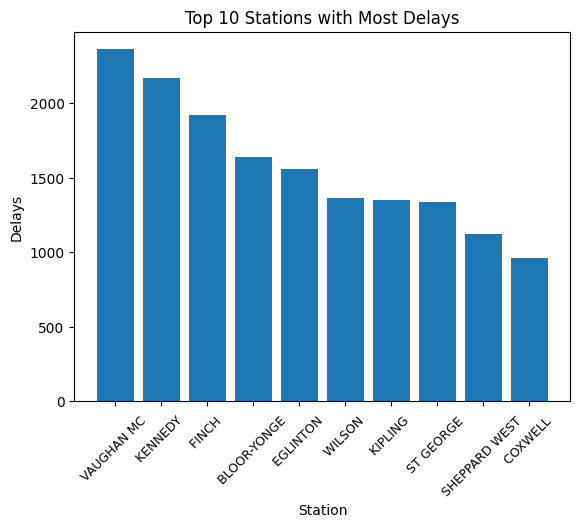

In [123]:
def stationdelays(df,title):
  station_list=df["Station"].unique().tolist()
  station_counts=df['Station'].value_counts().sort_index()
  sort_station=station_counts.sort_values(ascending=False).head(10) #sort top 10 delay times
  df_stationcounts = pd.DataFrame({'Station': sort_station.index, 'Count': sort_station.values})
  plt.bar(df_stationcounts['Station'], df_stationcounts['Count'])
  plt.xlabel('Station')
  plt.ylabel('Delays')
  plt.title(title)
  plt.xticks(fontsize=9,rotation=45)
  plt.show()
stationdelays(df,'Top 10 Stations with Most Delays')

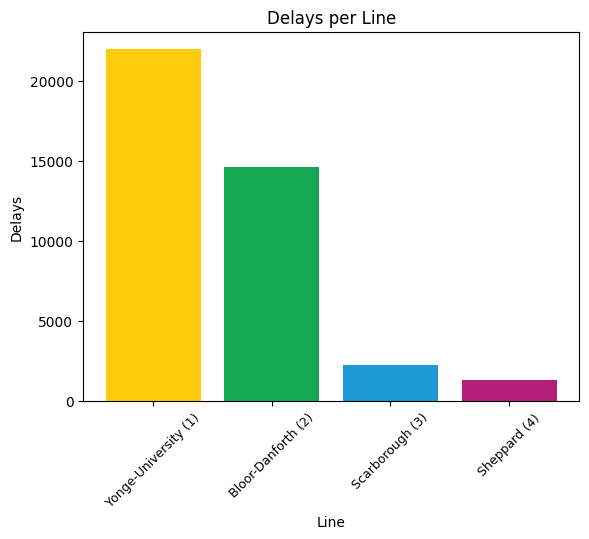

In [126]:
def linedelays(df,title):
  line_list=df["Line"].unique().tolist()
  line_counts=df['Line'].value_counts().sort_index()
  colour_mapping = {
    'Bloor-Danforth (2)': '#16A753',
    'Sheppard (4)': '#B32078',
    'Scarborough (3)':'#1F99D5',
    'Yonge-University (1)':'#FFCB0C',
  }
  sort_line=line_counts.sort_values(ascending=False) #sort lines by delay time
  df_linecounts = pd.DataFrame({'Line': sort_line.index, 'Count': sort_line.values})
  df_linecounts['Colour']=df_linecounts['Line'].map(colour_mapping)
  plt.bar(df_linecounts['Line'], df_linecounts['Count'],color=df_linecounts['Colour'])
  plt.xlabel('Line')
  plt.ylabel('Delays')
  plt.title(title)
  plt.xticks(fontsize=9,rotation=45)
  plt.show()
linedelays(df,'Delays per Line')

In [127]:
#Total delay time over stations
station_delay_sum = df.groupby('Station')['Min Delay'].sum().reset_index()
station_delay_sum=station_delay_sum.rename(columns={'Min Delay':'Total Min Delay'})
station_delay_sum=station_delay_sum.sort_values(by='Total Min Delay',ascending=False).head(75)
print(station_delay_sum)

             Station  Total Min Delay
31          KENNEDY             15641
4       BLOOR-YONGE             12671
66       VAUGHAN MC             10541
62        ST GEORGE              9760
19         EGLINTON              9465
..               ...              ...
38           LESLIE              1514
48  PIONEER VILLAGE              1416
14   DOWNSVIEW PARK              1372
3         BESSARION              1033
73  YORK UNIVERSITY               903

[75 rows x 2 columns]


In [128]:
#Incidents by year - get year, count frequency of years
df['Year']=df['Datetime'].dt.year
df['Month']=df['Datetime'].dt.month
df['Day']=df['Datetime'].dt.day
dfCOMP=df.drop(df[df['Year']==2023].index) #remove 2023 from the data as it's not finished
year_count=dfCOMP['Year'].value_counts().reset_index()
year_count.columns=['Year','Count']
year_count=year_count.sort_values(by='Year',ascending=True)
print(year_count.reset_index(drop=True))
print("\n")
month_count=dfCOMP['Month'].value_counts().reset_index()
month_count.columns=['Month','Count']
month_count=month_count.sort_values(by='Month',ascending=True)
print(month_count.reset_index(drop=True))

   Year  Count
0  2018   7049
1  2019   6682
2  2020   6796
3  2021   7318
4  2022   8849


    Month  Count
0       1   3376
1       2   2855
2       3   3074
3       4   3261
4       5   2957
5       6   2792
6       7   3083
7       8   2865
8       9   2885
9      10   3135
10     11   3237
11     12   3174


In [129]:
df['Month Year']=df['Datetime'].dt.to_period('M')
my_count=df['Month Year'].value_counts().reset_index()
my_count.columns=['Month Year','Count']
my_count=my_count.sort_values(by='Month Year',ascending=True).reset_index(drop=True)
print("In Chronological Order:")
print(my_count)
print("\n")
print("In Descending Order of Incident Frequency:")
print(my_count.sort_values(by='Count',ascending=False))

In Chronological Order:
   Month Year  Count
0     2018-01    696
1     2018-02    527
2     2018-03    568
3     2018-04    487
4     2018-05    596
..        ...    ...
60    2023-01    706
61    2023-02    640
62    2023-03    757
63    2023-04    676
64    2023-05    677

[65 rows x 2 columns]


In Descending Order of Incident Frequency:
   Month Year  Count
27    2020-04    933
48    2022-01    925
46    2021-11    915
47    2021-12    829
57    2022-10    777
..        ...    ...
41    2021-06    499
20    2019-09    491
3     2018-04    487
32    2020-09    432
29    2020-06    384

[65 rows x 2 columns]


In [130]:
#Including 2023
def timesplit(df):
  year_count=df['Year'].value_counts().reset_index()
  year_count.columns=['Year','Count']
  year_count=year_count.sort_values(by='Year',ascending=True)
  print(year_count.reset_index(drop=True))
  print("\n")
  month_count=df['Month'].value_counts().reset_index()
  month_count.columns=['Month','Count']
  month_count=month_count.sort_values(by='Month',ascending=True)
  print(month_count.reset_index(drop=True))
timesplit(df)

   Year  Count
0  2018   7049
1  2019   6682
2  2020   6796
3  2021   7318
4  2022   8849
5  2023   3456


    Month  Count
0       1   4082
1       2   3495
2       3   3831
3       4   3937
4       5   3634
5       6   2792
6       7   3083
7       8   2865
8       9   2885
9      10   3135
10     11   3237
11     12   3174


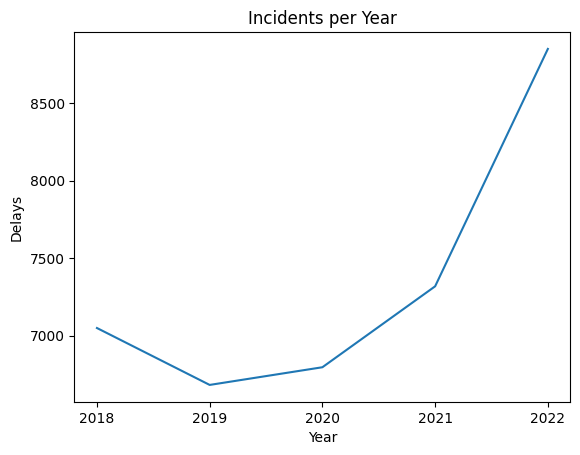

In [131]:
#Plotting delays by year excluding 2023
def yearplt(df,title):
  year_count=df['Year'].value_counts().reset_index()
  year_count.columns=['Year','Count']
  year_count=year_count.sort_values(by='Year',ascending=True)
  year_count=year_count.drop(year_count[year_count['Year']==2023].index)
  plt.plot(year_count['Year'],year_count['Count'])
  plt.xlabel('Year')
  plt.ylabel('Delays')
  plt.title(title)
  plt.xticks([2018,2019,2020,2021,2022])
  plt.show()
yearplt(df,'Incidents per Year')

   Year  Count
0  2018   1211
1  2019   1210
2  2020   1407
3  2021   1893
4  2022   2259
5  2023   1187


    Month  Count
0       1    947
1       2    853
2       3   1085
3       4    933
4       5    848
5       6    597
6       7    580
7       8    552
8       9    569
9      10    670
10     11    678
11     12    855


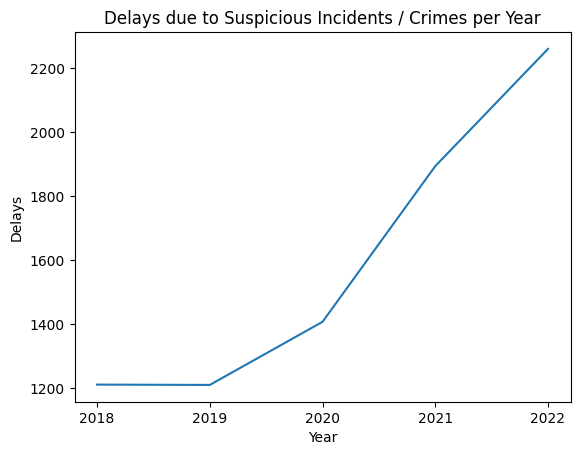

In [132]:
#Filtering for S crime
df_sus=df[df['Code'].str.startswith('S')]
timesplit(df_sus)
yearplt(df_sus, 'Delays due to Suspicious Incidents / Crimes per Year')

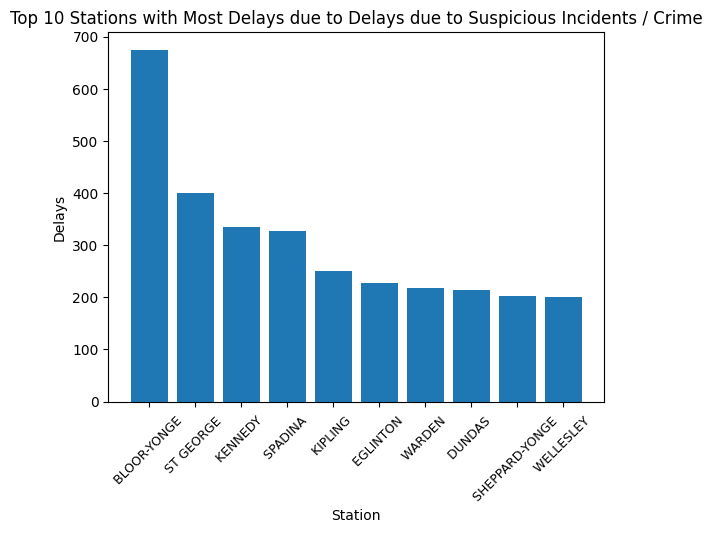

In [133]:
stationdelays(df_sus,'Top 10 Stations with Most Delays due to Delays due to Suspicious Incidents / Crime')

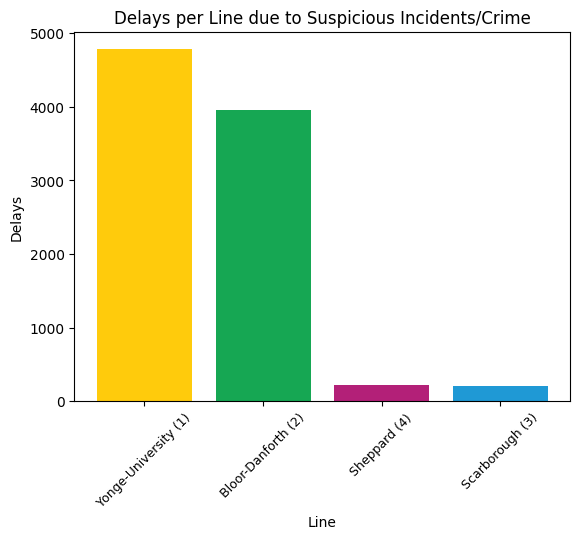

In [134]:
linedelays(df_sus,'Delays per Line due to Suspicious Incidents/Crime')